In [96]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2



In [45]:
tumor = []
path = './data/brain_tumor_dataset/yes/*.jpg'
for i in glob.iglob(path):
    img = cv2.imread(i)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)


In [46]:
healthy = []
path = './data/brain_tumor_dataset/no/*.jpg'
for i in glob.iglob(path):
    img = cv2.imread(i)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [52]:
healthy = np.array(healthy)
tumor = np.array(tumor)
ALL = np.concatenate((tumor, healthy))




In [53]:
tumor.shape, healthy.shape, ALL.shape

((154, 128, 128, 3), (91, 128, 128, 3), (245, 128, 128, 3))

In [63]:
def get_random_sample(arr, num):
    images = arr[np.random.choice(len(arr), num, replace = False)]
    return images

tumor_sample = get_random_sample(tumor, 5)
healthy_sample = get_random_sample(healthy, 5)

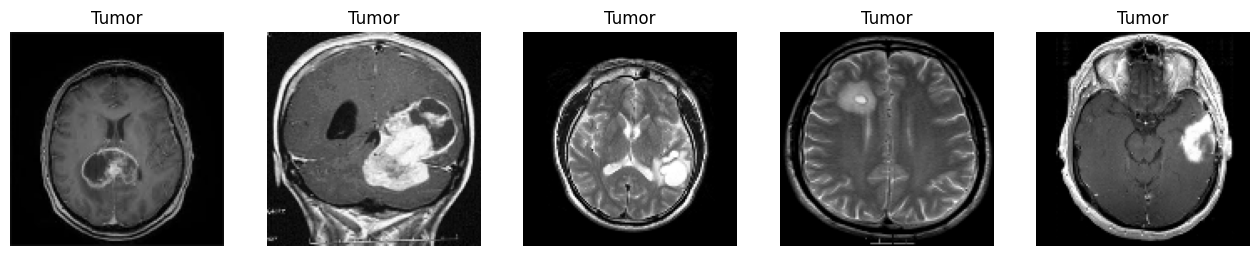

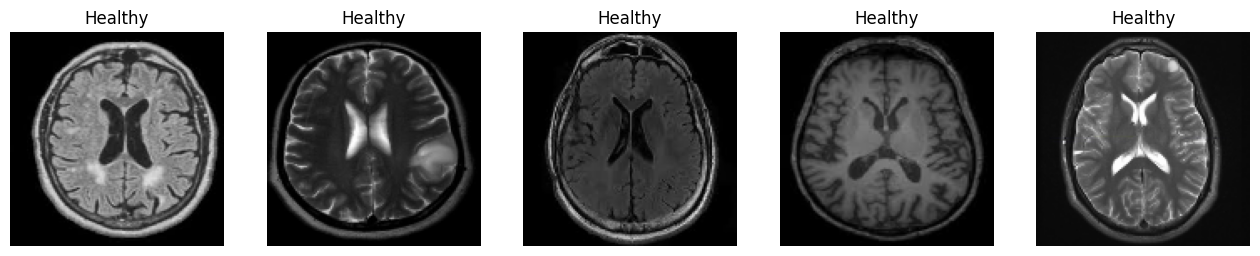

In [74]:
def plot_images(sample1, sample2, title1, title2):
    plt.figure(figsize=(16, 9))
    for i in range(len(sample1)):
        plt.subplot(1, len(sample1), i + 1)
        plt.imshow(sample1[i])
        plt.axis(False)
        plt.title(title1)

    plt.figure(figsize=(16, 9))
    for i in range(len(sample2)):
        plt.subplot(2, len(sample2), i + 1)
        plt.title(title2)
        plt.axis(False)
        plt.imshow(sample2[i])


plot_images(tumor_sample, healthy_sample, "Tumor", "Healthy")

In [99]:
class MRI(Dataset):
    def __init__(self, scores):
        self.scores = scores

    def __getitem__(self, index):
        return self.scores[index]
    
    def __len__(self):
        return len(self.scores)
    
    def __add__(self, other):
        return ConcatDataset([self, other])
    
 


34
